<a href="https://colab.research.google.com/github/Pilo1961/Deep_Learning/blob/master/proyecto_final/stackGan_infersent_2048-p-biasFalse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook setup

In [2]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# importa modulos propios
import sys
sys.path.append('/content/drive/My Drive/')

import model
#import util

Using TensorFlow backend.


In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.transform import rescale
from skimage import img_as_ubyte
import pickle
import datetime as dt

### Modulo de utiles

In [0]:
#esto se debe de ir al modulo util
def add_fileName(df):
  '''
    Add filename column to the ID-description list
  '''
  df['filename']='a'
  for index, row in df.iterrows():
      try:
        new_name = row['ID'][:-6] + '_' + row['ID'][-1] + '.jpg'
        row['filename']=new_name
      except:
        found_n.append(row['ID'])

  return df

def train_test(df):
  x_train = df[df.index % 5 != 0]     # Excludes every 5th row starting from 0
  x_test = df[df.index % 5 == 0]      # Selects every 5th row starting from 0
  #print(x_train.shape)
  #print(x_test.shape)  
  return x_train, x_test


# Load image
def load_image(img_id,src='Flicker8k_Dataset/'):
    I = imread('/content/drive/My Drive/'+src+img_id)
    #I = margin_img(I)
    return I

# Hacemos un pickle que tiene un arreglo de numpy con toda la informacion de las imagenes
# ojo:
#file not found:  2258277193_586949ec62.j_1.jpg
#file not found:  2258277193_586949ec62.j_2.jpg
#file not found:  2258277193_586949ec62.j_3.jpg
#file not found:  2258277193_586949ec62.j_4.jpg

def img_train_pickle(x_train):
  src='test_64/'
  img_train=[]
  print("Images to load: ", len(x_train["filename"]))
  for i, img_name in enumerate(x_train["filename"]):
    try:
      img=load_image(img_name,src)
      img_train.append(img)
    except:
      print("file not found: ",img_name)
    if i%3000==0: print("Loaded images: ",i)
  
  img_train=np.array(img_train)
  
  with open("/content/drive/My Drive/img_test_data.pkl", 'wb') as f:
    pickle.dump(img_train,f) 
  
def save_rgb_img(img, path, epoca=None):
    """
    Save a rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image infersent 2024, epoca {}".format(epoca))

    plt.savefig(path)
    plt.close()


# Load data
## Image list

In [5]:
# Load data
df = pd.read_csv("/content/drive/My Drive/Flickr8k.token.txt", sep='\t', names=['ID', 'Text'], index_col=False)
df=add_fileName(df)
print(df.shape)

# Remove entries with nan values
df.dropna(inplace=True)
df.isnull().values.any()
df.head()

#Quito los registros de una imagen que falta
df.drop([6730,6731,6732,6733,6734],inplace=True)
df.reset_index()
df.shape

(40460, 3)


(40455, 3)

# Embedding

In [0]:
import pickle
with open("/content/drive/My Drive/embeddings_jp/infersent_2048_encoding.pkl", 'rb') as f:
  embedding = pickle.load(f) 

In [7]:
print(embedding.shape)
embedding[:5]

(40455, 2048)


array([[0.39345706, 0.40068054, 0.        , ..., 0.25473678, 0.        ,
        0.        ],
       [0.45194066, 0.35207438, 0.17238629, ..., 0.29099917, 0.        ,
        0.        ],
       [0.24859764, 0.41610572, 0.01076891, ..., 0.47545895, 0.        ,
        0.        ],
       [0.18924333, 0.46832794, 0.17909272, ..., 0.42658257, 0.        ,
        0.        ],
       [0.29078767, 0.35777974, 0.12543346, ..., 0.4609754 , 0.        ,
        0.        ]], dtype=float32)

In [8]:
df_emb=pd.DataFrame(embedding)
df_emb.head()

#solo correr esto si se necesita borrar la foto que no esta
#Quito los registros de una imagen que falta
#df_emb.drop([6730,6731,6732,6733,6734],inplace=True)
#df_emb.reset_index()
#df_emb.shape

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.393457,0.400681,0.000000,0.605102,0.603657,0.0,0.000000,0.310660,0.460136,0.629839,0.000000,0.0,0.000000,0.429817,0.330119,0.199772,0.000000,0.466192,0.0,0.296616,0.0,0.110367,0.000000,0.010036,0.047128,0.0,0.000000,0.688111,0.292551,0.000000,0.375790,0.251747,0.0,0.0,0.000000,0.208159,0.17865,0.0,0.180510,0.623039,...,0.0,0.0,0.210284,0.028305,0.0,0.000000,0.306471,0.000000,0.455848,0.986642,0.468128,0.140055,0.471230,0.109100,0.572713,0.130740,0.165485,0.235110,0.160681,0.000000,0.248038,0.0,0.0,0.0,0.000000,0.614182,0.321173,0.288185,0.429266,0.518778,0.000000,0.0,0.359982,0.361368,0.266434,0.250522,0.319693,0.254737,0.0,0.0
1,0.451941,0.352074,0.172386,0.440772,0.005154,0.0,0.344489,0.334634,0.000000,0.000000,0.000000,0.0,0.000000,0.080569,0.180571,0.000000,0.298772,0.279546,0.0,0.932882,0.0,0.280277,0.349072,0.000000,0.000000,0.0,0.034793,0.447044,0.434647,0.825875,0.326774,0.238294,0.0,0.0,0.515401,0.000000,0.04105,0.0,0.337161,0.238164,...,0.0,0.0,0.519621,0.807512,0.0,0.104816,0.360734,0.401849,0.516129,0.945788,0.300323,0.406306,0.603262,0.371539,0.443428,0.057582,0.697827,0.128658,0.482927,0.000000,0.498570,0.0,0.0,0.0,0.278461,0.429938,0.358614,0.002374,0.684432,0.238420,0.740736,0.0,0.264105,0.332310,0.084901,0.255255,0.404508,0.290999,0.0,0.0
2,0.248598,0.416106,0.010769,0.543384,0.015789,0.0,0.386013,0.383023,0.000000,0.366081,0.000000,0.0,0.369491,0.142123,0.290697,0.000000,0.051800,0.000000,0.0,0.403375,0.0,0.271004,0.000000,0.000000,0.000000,0.0,0.000000,0.292453,0.295890,0.766576,0.272735,0.042542,0.0,0.0,0.440485,0.000000,0.00000,0.0,0.286601,0.406133,...,0.0,0.0,0.135493,0.458384,0.0,0.074983,0.333794,0.251219,0.212585,0.762402,0.119447,0.384135,0.442917,0.325842,0.306054,0.024473,0.833010,0.279502,0.289738,0.000000,0.602752,0.0,0.0,0.0,0.000000,0.508006,0.362864,0.000000,0.809515,0.056514,0.418886,0.0,0.112307,0.404958,0.074921,0.486090,0.389143,0.475459,0.0,0.0
3,0.189243,0.468328,0.179093,0.690814,0.063529,0.0,0.317280,0.369442,0.000000,0.576502,0.254274,0.0,0.000000,0.327239,0.103807,0.029828,0.000000,0.000000,0.0,0.391937,0.0,0.343289,0.098532,0.000000,0.000000,0.0,0.103317,0.448898,0.193215,0.680711,0.130816,0.235150,0.0,0.0,0.264838,0.147049,0.00000,0.0,0.054174,0.563837,...,0.0,0.0,0.057120,0.461223,0.0,0.000000,0.287317,0.336544,0.318999,0.742067,0.162903,0.477865,0.267034,0.250423,0.284150,0.115264,0.709942,0.201977,0.283285,0.051158,0.838226,0.0,0.0,0.0,0.012997,0.469488,0.238626,0.000000,0.830770,0.097226,0.132916,0.0,0.055869,0.392147,0.074827,0.239808,0.347895,0.426583,0.0,0.0
4,0.290788,0.357780,0.125433,0.487169,0.203958,0.0,0.000000,0.249074,0.345931,0.179054,0.000000,0.0,0.055264,0.209145,0.168953,0.061240,0.277065,0.585758,0.0,0.563393,0.0,0.281685,0.000000,0.000000,0.025029,0.0,0.000000,0.523397,0.439483,0.290979,0.403227,0.208883,0.0,0.0,0.273554,0.000000,0.00000,0.0,0.366652,0.219396,...,0.0,0.0,0.481603,0.828163,0.0,0.000000,0.431000,0.000000,0.501454,0.786829,0.265662,0.412488,0.631893,0.290748,0.539540,0.385839,0.218969,0.354981,0.099708,0.000000,0.520495,0.0,0.0,0.0,0.042597,0.609290,0.541537,0.129401,0.590753,0.405863,0.461316,0.0,0.372925,0.251038,0.000756,0.191232,0.499930,0.460975,0.0,0.0


# Train test split

In [9]:
x_train, x_test= train_test(df)
print(x_train.shape)
print(x_test.shape)
x_train.head()

(32364, 3)
(8091, 3)


,ID,Text,filename
1,1000268201_693b08cb0e.jpg#1,A girl going into a wooden building .,1000268201_693b08cb0e_1.jpg
2,1000268201_693b08cb0e.jpg#2,A little girl climbing into a wooden playhouse .,1000268201_693b08cb0e_2.jpg
3,1000268201_693b08cb0e.jpg#3,A little girl climbing the stairs to her playh...,1000268201_693b08cb0e_3.jpg
4,1000268201_693b08cb0e.jpg#4,A little girl in a pink dress going into a woo...,1000268201_693b08cb0e_4.jpg
6,1001773457_577c3a7d70.jpg#1,A black dog and a tri-colored dog playing with...,1001773457_577c3a7d70_1.jpg


In [10]:
emb_train, emb_test= train_test(df_emb)
emb_train=emb_train.to_numpy()
emb_test=emb_test.to_numpy()
print(emb_train.shape)
print(emb_test.shape)
print(emb_train[:5])

#emb_train=embedding
#print(emb_train.shape)
#emb_train[:5]

(32364, 2048)
(8091, 2048)
[[0.45194066 0.35207438 0.17238629 ... 0.29099917 0.         0.        ]
 [0.24859764 0.41610572 0.01076891 ... 0.47545895 0.         0.        ]
 [0.18924333 0.46832794 0.17909272 ... 0.42658257 0.         0.        ]
 [0.29078767 0.35777974 0.12543346 ... 0.4609754  0.         0.        ]
 [0.37243274 0.         0.11580959 ... 0.5485679  0.         0.        ]]


# Prepara imagenes

In [0]:
  with open("/content/drive/My Drive/img_train_data.pkl", 'rb') as f:
    img_train=pickle.load(f) 

In [12]:
len(img_train)

32364

# Creating models


In [13]:
from tensorflow.keras.losses import binary_crossentropy
from keras.optimizers import adam
from keras import backend as K
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from tensorflow.keras.layers import concatenate, Embedding, Dense, Dropout, Reshape, UpSampling2D, Conv2D, BatchNormalization, Activation, Input, Concatenate, LeakyReLU, Flatten, Lambda

Using TensorFlow backend.


In [0]:
def KL_loss(y_true, y_pred):
    mean = y_pred[:, :128]
    logsigma = y_pred[:, :128]
    loss = -logsigma + .5 * (-1 + K.exp(2. * logsigma) + K.square(mean))
    loss = K.mean(loss)
    return loss

In [0]:
#!python3
#conditional Augmentation model
from keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Embedding, Dense, Dropout, Reshape, UpSampling2D, Conv2D, BatchNormalization, Activation, Input, Concatenate, LeakyReLU, Flatten, Lambda

def create_c(x):
  '''
    Función auxiliar a la función create_CA_model
    genera variables condicionales
    Mete ruido en la variable de entrada
  '''
  mean=x[:,:128]
  log_sigma=x[:,128:]
  stddev=K.exp(log_sigma)
  epsilon=K.random_normal(shape=K.constant((mean.shape[1], ), dtype='int32'))
  c=stddev*epsilon+mean

  return c

def create_CA_model(len_embedding=20):
  '''
    Red que genera el conditional augmentation
    ** params:
      * len_embedding: longitud del embedding utilizado para los textos
    ** salida:
      * Conditional augmentation network
  '''
  input_layer=Input(shape=(len_embedding,))
  layer=Dense(256)(input_layer)
  mean_logsigma=LeakyReLU(alpha=0.2)(layer)
  c=Lambda(create_c)(mean_logsigma)

  CA_model=Model(inputs=[input_layer],outputs=[c])
  return CA_model

# Crear red generadora
def create_gen_st1(len_embedding=20):
  '''
  Crea la red generadora de la primera etapa
  '''
  #conditional augmentation
  input_layer=Input(shape=(len_embedding,))
  layer=Dense(256)(input_layer)
  mean_logsigma=LeakyReLU(alpha=0.2)(layer)
  c=Lambda(create_c)(mean_logsigma)

  #noise from normal dist.
  input_layer2=Input(shape=(100,))

  #generate input. conditional augmentation + noise
  gen_input=Concatenate(axis=1)([c,input_layer2])

  #upsampling
  gen_model=Dense(units=128*8*4*4,activation="relu",use_bias=False)(gen_input)
  gen_model=Reshape((4,4,128*8),input_shape=(128*8*4*4,))(gen_model)

  gen_model=UpSampling2D(size=(2,2))(gen_model)
  gen_model=Conv2D(512,kernel_size=3, padding='same', strides=1,use_bias=False)(gen_model)
  gen_model=BatchNormalization()(gen_model)
  gen_model=Activation('relu')(gen_model)

  gen_model=UpSampling2D(size=(2,2))(gen_model)
  gen_model=Conv2D(256,kernel_size=3, padding='same', strides=1,use_bias=False)(gen_model)
  gen_model=BatchNormalization()(gen_model)
  gen_model=Activation('relu')(gen_model)

  gen_model=UpSampling2D(size=(2,2))(gen_model)
  gen_model=Conv2D(128,kernel_size=3, padding='same', strides=1,use_bias=False)(gen_model)
  gen_model=BatchNormalization()(gen_model)
  gen_model=Activation('relu')(gen_model)

  gen_model=UpSampling2D(size=(2,2))(gen_model)
  gen_model=Conv2D(64,kernel_size=3, padding='same', strides=1,use_bias=False)(gen_model)
  gen_model=BatchNormalization()(gen_model)
  gen_model=Activation('relu')(gen_model)

  out=Conv2D(3,kernel_size=3, padding='same', strides=1,activation='tanh')(gen_model)

  generator=Model(inputs=[input_layer,input_layer2],outputs=[out,mean_logsigma])
  return generator

 # Crea una red con layers Embedding, LSTM, Dense
#discriminator = Sequential()
def create_disc_st1():
  '''
  Crea la red discrimidaora de la primera etapa
  '''

  input_layer=Input(shape=(64,64,3))

  disc=Conv2D(64,kernel_size=(4,4), padding='same', strides=2,use_bias=False)(input_layer)
  disc=LeakyReLU(alpha=0.2)(disc)

  disc=Conv2D(128,kernel_size=(4,4), padding='same', strides=2,use_bias=False)(disc)
  disc=BatchNormalization()(disc)
  disc=LeakyReLU(alpha=0.2)(disc)

  disc=Conv2D(256,kernel_size=(4,4), padding='same', strides=2,use_bias=False)(disc)
  disc=BatchNormalization()(disc)
  disc=LeakyReLU(alpha=0.2)(disc)

  disc=Conv2D(512,kernel_size=(4,4), padding='same', strides=2,use_bias=False)(disc)
  disc=BatchNormalization()(disc)
  disc=LeakyReLU(alpha=0.2)(disc)

  input_layer2=Input(shape=(4,4,128))

  merged_input=concatenate([disc,input_layer2])

  disc2=Conv2D(64*8,kernel_size=1, padding='same', strides=1)(merged_input)
  disc2=BatchNormalization()(disc2)
  disc2=LeakyReLU(alpha=0.2)(disc2)

  disc2=Flatten()(disc2)
  disc2=Dense(1,activation='sigmoid')(disc2)

  return Model(inputs=[input_layer,input_layer2],outputs=[disc2])

def create_adversarial_model(gen, disc, len_embedding=20):
  input_layer=Input(shape=(len_embedding,))
  input_layer2=Input(shape=(100,))
  input_layer3=Input(shape=(4,4,128))

  x, mean_logsigma= gen([input_layer,input_layer2])

  disc.trainable=False
  valid=disc([x,input_layer3])

  model=Model(inputs=[input_layer,input_layer2,input_layer3],outputs=[valid,mean_logsigma])
  return model

In [0]:
len_embedding=2048

ca_model = create_CA_model(len_embedding=len_embedding)
ca_model.compile(loss="binary_crossentropy", optimizer="adam")

stage1_dis = create_disc_st1()
stage1_dis.compile(loss='binary_crossentropy', optimizer="adam")#dis_optimizer)
#stage1_dis.load_weights("/content/drive/My Drive/red_infersent_2048/stage1_dis_50.h5")

stage1_gen = create_gen_st1(len_embedding=len_embedding)
stage1_gen.compile(loss="mse", optimizer="adam")#gen_optimizer)
#stage1_gen.load_weights("/content/drive/My Drive/red_infersent_2048/stage1_gen_50.h5")

adversarial_model = create_adversarial_model(gen=stage1_gen, disc=stage1_dis,len_embedding=len_embedding)
adversarial_model.compile(loss=['binary_crossentropy', KL_loss], loss_weights=[1, 2.0],
                          optimizer="adam", metrics=None)#gen_optimizer, metrics=None)

# Train

Earlier, label/target values for a classifier were 0 or 1; 0 for fake images and 1 for real images. Because of this, GANs were prone to adversarial examples, which are inputs to a neural network that result in an incorrect output from the network. Label smoothing is an approach to provide smoothed labels to the discriminator network. This means we can have decimal values such as 0.9 (true), 0.8 (true), 0.1 (fake), or 0.2 (fake), instead of labeling every example as either 1 (true) or 0 (fake). We smooth the target values (label values) of the real images as well as of the fake images. Label smoothing can reduce the risk of adversarial examples in GANs. To apply label smoothing, assign the labels 0.9, 0.8, and 0.7, and 0.1, 0.2, and 0.3, to the images. To find out more about label smoothing, refer to the following paper.

[Improved techniques for training GAN](https://arxiv.org/pdf/1606.03498.pdf)

In [0]:

image_size = 64
z_dim = 100
stage1_generator_lr = 0.0002
stage1_discriminator_lr = 0.0002
stage1_lr_decay_step = 600
epochs = 1000
condition_dim = 128

In [0]:
dis_optimizer = adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)
gen_optimizer = adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)

Epoch is: 0
Number of batches 505
Batch:1
d_loss:6.477146804332733
g_loss:[1.2570576667785645, 0.7835218906402588, 0.23676787316799164]
Batch:101
d_loss:0.5674266051501036
g_loss:[0.602556586265564, 0.5898206233978271, 0.006367971189320087]
Batch:201
d_loss:0.593589790565602
g_loss:[1.1336917877197266, 1.126387119293213, 0.0036523262970149517]
Batch:301
d_loss:0.6161473509855568
g_loss:[0.681648850440979, 0.6762940287590027, 0.0026773985009640455]
Batch:401
d_loss:0.6232148756098468
g_loss:[2.658954620361328, 2.654844284057617, 0.002055213088169694]
Batch:501
d_loss:0.5684905805101153
g_loss:[0.5736801028251648, 0.5702430009841919, 0.0017185402102768421]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Guardo 3 imagenes


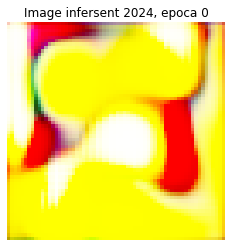

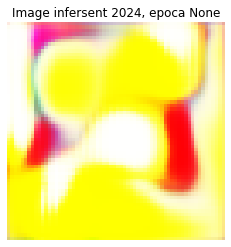

Epoch is: 1
Number of batches 505
Batch:1
d_loss:0.5875292530545266
g_loss:[0.5543961524963379, 0.551112174987793, 0.0016420009778812528]
Batch:101
d_loss:0.6067332856619032
g_loss:[0.8031496405601501, 0.8002427816390991, 0.0014534263173118234]
Batch:201
d_loss:0.6285662667141878
g_loss:[0.8020289540290833, 0.7994980812072754, 0.001265448983758688]
Batch:301
d_loss:0.5785802099471766
g_loss:[0.7201253175735474, 0.7178810238838196, 0.0011221579043194652]
Batch:401
d_loss:0.5612209102109773
g_loss:[0.8535616993904114, 0.8515663146972656, 0.0009976886212825775]
Batch:501
d_loss:0.5667942137079081
g_loss:[0.910891056060791, 0.9089874029159546, 0.0009518238948658109]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Guardo 3 imagenes


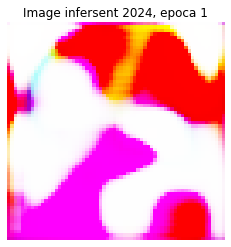

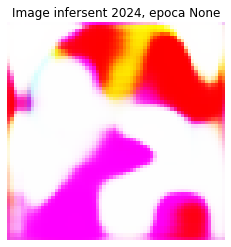

Epoch is: 2
Number of batches 505
Batch:1
d_loss:0.5769596814479883
g_loss:[0.7309104800224304, 0.7290920615196228, 0.0009092023246921599]
Batch:101
d_loss:0.605640844674781
g_loss:[0.9714442491531372, 0.9696983098983765, 0.0008729719556868076]
Batch:201
d_loss:0.6312778190040262
g_loss:[0.8289738893508911, 0.8273437023162842, 0.000815098115708679]
Batch:301
d_loss:0.5634795697151276
g_loss:[0.7398738265037537, 0.7383646965026855, 0.0007545789703726768]
Batch:401
d_loss:0.5542589064134518
g_loss:[0.8527641892433167, 0.8513146638870239, 0.000724767567589879]
Batch:501
d_loss:0.5595222572883358
g_loss:[0.9074748754501343, 0.9060978293418884, 0.0006885360926389694]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Guardo 3 imagenes


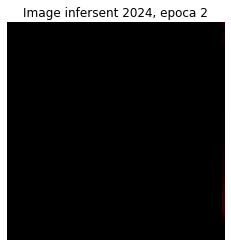

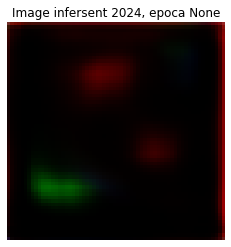

Epoch is: 3
Number of batches 505
Batch:1
d_loss:0.5659897410114354
g_loss:[0.9084135890007019, 0.9070929884910583, 0.000660294434055686]
Batch:101
d_loss:0.5949237877266569
g_loss:[0.7159813046455383, 0.7146695852279663, 0.0006558459135703743]
Batch:201
d_loss:0.5692186988890171
g_loss:[0.8238703608512878, 0.8226068615913391, 0.0006317438674159348]
Batch:301
d_loss:0.5613575238166959
g_loss:[0.7643564343452454, 0.7631424069404602, 0.0006070280214771628]
Batch:401
d_loss:0.5436719618737698
g_loss:[0.7968258857727051, 0.7956542372703552, 0.0005858145304955542]
Batch:501
d_loss:0.5726148971007206
g_loss:[0.9577864408493042, 0.9566856026649475, 0.0005504205473698676]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Guardo 3 imagenes


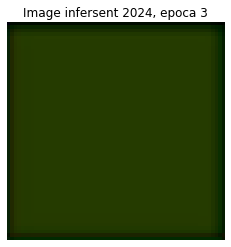

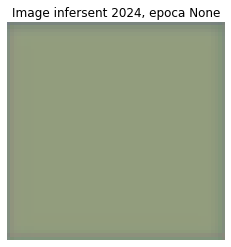

Epoch is: 4
Number of batches 505
Batch:1
d_loss:0.5919223026139662
g_loss:[1.0050408840179443, 1.0039433240890503, 0.0005487787420861423]
Batch:101
d_loss:0.5787432596607687
g_loss:[0.7514429688453674, 0.7503782510757446, 0.0005323556251823902]
Batch:201
d_loss:0.5709417803409451
g_loss:[0.9205871224403381, 0.9195407629013062, 0.0005231887917034328]
Batch:301
d_loss:0.572335954011578
g_loss:[0.89572674036026, 0.8946990966796875, 0.0005138323176652193]
Batch:401
d_loss:0.551867848233087
g_loss:[0.7935028672218323, 0.7924820184707642, 0.0005104310112074018]
Batch:501
d_loss:0.5466808531068637
g_loss:[0.8134629130363464, 0.8125187158584595, 0.00047208601608872414]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Guardo 3 imagenes


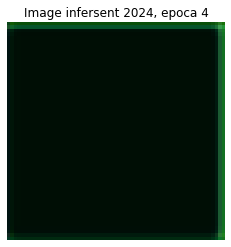

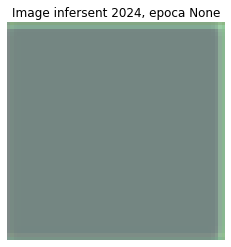

Epoch is: 5
Number of batches 505
Batch:1
d_loss:0.5907668377067239
g_loss:[0.7314781546592712, 0.7305557727813721, 0.0004611846525222063]
Batch:101
d_loss:0.5543079601993668
g_loss:[0.8242061138153076, 0.8232433795928955, 0.0004813540435861796]
Batch:201
d_loss:0.561868029244124
g_loss:[0.7733202576637268, 0.7724217176437378, 0.00044926293776370585]
Batch:301
d_loss:0.5559375069933594
g_loss:[0.6547168493270874, 0.6538176536560059, 0.000449608254712075]
Batch:401
d_loss:0.5502070466204714
g_loss:[0.6988590359687805, 0.6977039575576782, 0.0005775374011136591]
Batch:501
d_loss:0.5479822369907197
g_loss:[0.3652630150318146, 0.3644220530986786, 0.0004204779979772866]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Guardo 3 imagenes


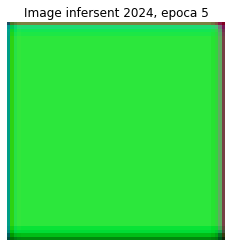

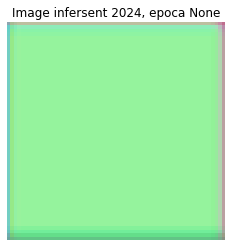

Epoch is: 6
Number of batches 505
Batch:1
d_loss:0.5709002681978745
g_loss:[0.4871331751346588, 0.4863429069519043, 0.0003951287071686238]
Batch:101
d_loss:0.5447248997161296
g_loss:[0.38357532024383545, 0.382736474275589, 0.0004194248467683792]
Batch:201
d_loss:0.5565869671168002
g_loss:[1.0075154304504395, 1.0061824321746826, 0.0006664717220701277]
Batch:301
d_loss:0.5454447830695699
g_loss:[0.46348869800567627, 0.4621503949165344, 0.0006691584130749106]
Batch:401
d_loss:0.5511481017265396
g_loss:[0.6906623840332031, 0.6883345246315002, 0.001163926674053073]
Batch:501
d_loss:0.5452204011508002
g_loss:[0.541368305683136, 0.5389358401298523, 0.0012162349885329604]
Guardo 3 imagenes


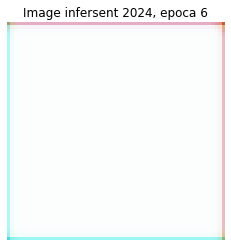

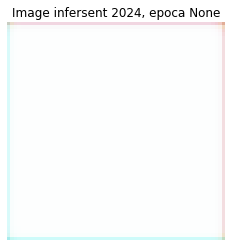

Epoch is: 7
Number of batches 505
Batch:1
d_loss:0.5613765018315462
g_loss:[0.8122485876083374, 0.8107869029045105, 0.0007308335043489933]
Batch:101
d_loss:0.5455372737724247
g_loss:[0.8376314640045166, 0.8355487585067749, 0.0010413454147055745]
Batch:201
d_loss:0.5505372337829613
g_loss:[0.7497044801712036, 0.747288703918457, 0.0012078951112926006]
Batch:301
d_loss:0.5450211384404611
g_loss:[0.5206009745597839, 0.519216775894165, 0.0006920988089405]
Batch:401
d_loss:0.54938090944961
g_loss:[0.7349827289581299, 0.7335245609283447, 0.0007290976354852319]
Batch:501
d_loss:0.5445210228288033
g_loss:[0.7246766090393066, 0.7239589691162109, 0.0003588083491194993]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Guardo 3 imagenes


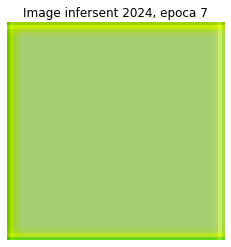

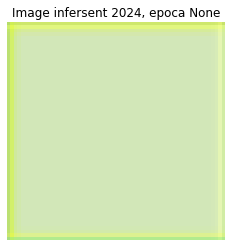

Epoch is: 8
Number of batches 505
Batch:1
d_loss:0.5533637469798123
g_loss:[0.6490787267684937, 0.6484309434890747, 0.0003238785720895976]
Batch:101
d_loss:0.5442442626365391
g_loss:[0.6136868596076965, 0.6127269864082336, 0.0004799224261660129]
Batch:201
d_loss:0.5484455921891822
g_loss:[1.0544947385787964, 1.0535435676574707, 0.00047557963989675045]
Batch:301
d_loss:0.54507260450373
g_loss:[0.5541324615478516, 0.5523062944412231, 0.000913071446120739]
Batch:401
d_loss:0.5467485309472977
g_loss:[0.8291817903518677, 0.8282778263092041, 0.00045199593296274543]
Batch:501
d_loss:0.5421043776636907
g_loss:[0.6738489866256714, 0.672641396522522, 0.0006037877174094319]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Guardo 3 imagenes


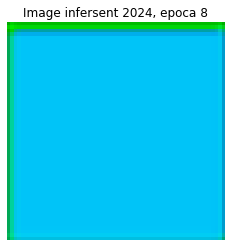

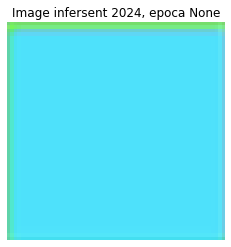

Epoch is: 9
Number of batches 505
Batch:1
d_loss:0.5481446630242317
g_loss:[0.6352616548538208, 0.6342780590057373, 0.0004918075865134597]
Batch:101
d_loss:0.5443990060948636
g_loss:[0.6979802846908569, 0.6964260339736938, 0.0007771160453557968]
Batch:201
d_loss:0.5464383545827332
g_loss:[0.7801154255867004, 0.7787672281265259, 0.0006741073448210955]
Batch:301
d_loss:0.5420786743620738
g_loss:[0.6828703284263611, 0.6814412474632263, 0.0007145374547690153]
Batch:401
d_loss:0.5429790821763163
g_loss:[0.8220772743225098, 0.8207097053527832, 0.000683773192577064]
Batch:501
d_loss:0.5436964473351509
g_loss:[0.5958123207092285, 0.5936619639396667, 0.0010751716326922178]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Guardo 3 imagenes


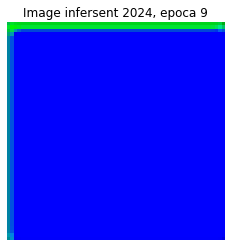

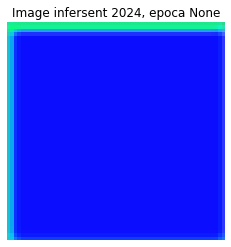

Epoch is: 10
Number of batches 505
Batch:1
d_loss:0.54650415046126
g_loss:[0.5949863791465759, 0.5931583046913147, 0.0009140424663200974]
Batch:101
d_loss:0.5432508274025167
g_loss:[0.8126108050346375, 0.8108139634132385, 0.0008984164451248944]
Batch:201
d_loss:0.5434685949985578
g_loss:[0.7807291746139526, 0.7798591256141663, 0.0004350171366240829]


In [0]:
batch_size=64
initial_epoch=0
epochs=800
run=1

real_labels = np.ones((batch_size, 1), dtype=float) * 0.9
fake_labels = np.zeros((batch_size, 1), dtype=float) * 0.1

for epoch in range(initial_epoch,epochs):
  print("========================================")
  print("Epoch is:", epoch)
  print("Number of batches", int(img_train.shape[0] / batch_size))

  gen_losses = []
  dis_losses = []

  number_of_batches = int(img_train.shape[0] / batch_size)
  for index in range(number_of_batches):
    #print("Batch:{}".format(index+1))

     # Create a batch of noise vectors
    z_noise = np.random.normal(0, 1, size=(batch_size, z_dim))
    image_batch = img_train[index * batch_size:(index + 1) * batch_size]
    embedding_batch = emb_train[index * batch_size:(index + 1) * batch_size]

    # Normalize images
    image_batch = image_batch/255 #(image_batch - 127.5) / 127.5

    fake_images, _ = stage1_gen.predict([embedding_batch, z_noise], verbose=3)
    
    #embedding compression
    #compressed_embedding = np.hstack((embedding_batch,embedding_batch))
    compressed_embedding = np.reshape(embedding_batch, (batch_size, 4, 4, condition_dim))

    #calc losses
    dis_loss_real = stage1_dis.train_on_batch([image_batch, compressed_embedding],np.reshape(real_labels, (batch_size, 1)))
    dis_loss_fake = stage1_dis.train_on_batch([fake_images, compressed_embedding],np.reshape(fake_labels, (batch_size, 1)))
    dis_loss_wrong = stage1_dis.train_on_batch([image_batch[:(batch_size - 1)], compressed_embedding[1:]],np.reshape(fake_labels[1:], (batch_size-1, 1)))

    g_loss = adversarial_model.train_on_batch([embedding_batch, z_noise, compressed_embedding],[K.ones((batch_size, 1)) * 0.9, K.ones((batch_size, 256)) * 0.9])

    d_loss = 0.5 * np.add(dis_loss_real, 0.5 * np.add(dis_loss_wrong, dis_loss_fake))

    if index%100 ==0:
      print("Batch:{}".format(index+1))
      print("d_loss:{}".format(d_loss))  
      print("g_loss:{}".format(g_loss))

    dis_losses.append(d_loss)
    gen_losses.append(g_loss)

  if epoch % 1 == 0:
    # empieza a guardar desde época 0
    print("Guardo 3 imagenes")                     
    z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
    embedding_batch = emb_test[0:batch_size]
    fake_images, _ = stage1_gen.predict_on_batch([embedding_batch, z_noise2])

    # Save images
    for i, img in enumerate(fake_images[:1]):
      show_rgb_img(img,epoch)
      show_rgb_img((fake_images[60]+1)/2)

  #if epoch % 50 == 0:
  #  print("Guardo pesos")
  #  stage1_gen.save_weights("/content/drive/My Drive/red_infersent_2048/stage1_gen_{}.h5".format(epoch))
  #  stage1_dis.save_weights("/content/drive/My Drive/red_infersent_2048/stage1_dis_{}.h5".format(epoch))

#Aqui solamente agregue el parametro de bias=false en las redes

In [0]:
  def show_rgb_img(img, epoca=None):
    """
    Save a rgb image
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title("Image infersent 2024, epoca {}".format(epoca))

    plt.show()
    #plt.close()

In [0]:
#salva alguna imagenes

z_noise2 = np.random.normal(0, 1, size=(batch_size, z_dim))
embedding_batch = emb_test[0:batch_size]
fake_images, _ = stage1_gen.predict_on_batch([embedding_batch, z_noise2])

  # Save images
for i, img in enumerate(fake_images[:10]):
  save_rgb_img(img, "/content/drive/My Drive/fake_img/gen_{}_{}.png".format(epoch, i))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [0]:
# guarda los pesos de la red
stage1_gen.save_weights("/content/drive/My Drive/red_infersent_2048/stage1_gen_{}.h5".format(epoch))
stage1_dis.save_weights("/content/drive/My Drive/red_infersent_2048/stage1_gen_{}.h5".format(epoch))